In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import prep_for_model_runs as prep
import model_params_class as mp
import run_models as run
import sys
import generate_matrix as inputs
sys.path.append('../')

resident hours --- white: 92.1702477472447, black: 92.744517984031
saving group size matrix to GROUP_SIZE.csv
5.4792118701645955e-06
5.714285714285714
12.857142857142858
12.857142857142858
white of black white police 0.7352216748768473 black: 0.26477832512315275
white --> police 6.895951865
 white --> police_contact 0.014371166754051723 + 0.005175545815948276 = 0.01954671257
72


/Users/rachelwarren/projects/CPE-COVID-disparities/model/generate_matrix.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contact_matrix_pre_sip[g] = 0.0
/Users/rachelwarren/projects/CPE-COVID-disparities/model/generate_matrix.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_at_home['hours_prop'] = white_at_home['Race_Home_Hours'] / white_at_home['Race_Home_Hours'].sum()
/Users/rachelwarren/projects/CPE-COVID-disparities/model/generate_matrix.py:267: SettingWithCopyWarning: 
A value is tryin

In [2]:
import sys
!conda install --yes --prefix {sys.prefix} matplotlib

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/covid_cpe

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1k             |       h9ed2024_0         2.2 MB
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following packages will be UPDATED:

  openssl                                 1.1.1j-h9ed2024_0 --> 1.1.1k-h9ed2024_0



openssl-1.1.1k       | 2.2 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


## Deterministic SIR model for multi-groups 
See: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4002176/


The model works like this: 
- Let's say we have N groups with size n_0 .... n_N
- Define four vectors (S = 'Susceptible, I = Infected, R = Recovered, D = Died) for each of the groups
    - for example: $\vec{I} = < I_0, I_1 \dots I_N >$ is the vector for the number of currently infected people in each subpopulation
- Assume a "contact matrix" $C = c_{ij} $ where $c_{ij}$ is the expected rate of contacts between groups i and j.
    - for example if $c_{i,j}$ = 0.1 that means that average number of contacts that an individual in group i has with group j is 0.1 --> i.e. there is a 1/10 chance they see anyone 
- Assume a "transmission matrix" $T = t_{ij}$ where $t_{ij}$  is the expected transmission between groups i and j if they make contact
    - The following code assumes that this is 1 (e.g. transmission rate is rolled into contact matrix) and is constant across groups. 
    - In a more sophisticated model, this assumption is not true. The transmission rate should not even be reciprocal. For example, if police are wearing masks when they interact with a community member, but there hands are equipment are dirty transmission rate could be higher in one direction. Transmission rate could also be higher for different types of interactions
- $\vec{\gamma}$ is the recovery rate .. e.g. $\gamma_i$ the likelihood that on a given day a sick person in group i recovers. We are using 1/14
- $\vec{\mu}$ is the death rate (divided by average disease duration) for each group

Combining contact and transmission, we can define a vector $\vec{\lambda}$ where $\lambda_i$ is the new infection rate (called the force of infection in the literature). 

- Force of infection = contact x transmission or $\lambda_i = \sum_j^N c_{ij} * t_{ij} $

Given $\vec{\lambda}$ the vector with contact rate * transmission rate, we can define our differential equations as follows:(Note that $t$ is current time and $t-1$ is previous time point. 

- Sub population totals : $\vec{N} = \vec{I_t} + \vec{R_t} + \vec{S_t} + \vec{D_t}$
- Susceptible number of people by sup-population: $\vec{S_t} = \vec{S_{t-1}} - \vec{I_{t-1}}$
- Infected by subpopulation $\vec{I_t} = \vec{I_{t-1}}+  \vec{\lambda} * \vec{S_{t-1}} * \frac{\vec{I_{t-1}}}{\vec{N}} - \vec{\gamma} \vec{I_{t-1}} - \vec{\mu} \vec{I_{t-1}}$ 
    - $\vec{I_t} =$ infected people before + newly infected people - infected people who recover
    - newly infected people = susceptible population * contact rate * transmission rate * proportion of population infected 
    - $\frac{\vec{I_{t-1}}}{\vec{N}}$ is the proportion of members of each group that are infected
- Recovered by Group: $\vec{R_t} = \vec{R_{t-1}} + \vec{\gamma} \vec{I_{t-1}}$

The implementation of this model does not try to count the number of individuals who have died, which simplifies it. 

In [3]:
def clean_df_names(df):
    df.columns = df.columns.str.strip()
    df.index = df.index.map(lambda s: s.strip())
    return df

In [4]:
"""Run multiple versions of the model, varying certain parameters to quantify uncertainty

params
------
base_dir: String
    the name of the directory where contact matrices and group size matrices are stored
    
starting_params: object of class ModelParams
    contains the initial parameters for the original model run
    
prison_peak_date: Int
    the day on which the prison infection rate peaks
    
days: Int
    the number of days to run the model for
    
returns
-------
monster_summary_stats: a DataFrame of all of the summary statistics for the model runs
infection_maps: a dictionary where the keys are stylized versions of a list of the starting parameters and the 
    values are infection_df's generated by these combinations of starting parameters
pd.concat(pop_sizes): a DataFrame that is a stacked version of all pop_size_df's output by the various model runs
"""
def run_models(policy_input_dirs, starting_params, days):
    monster_summary_stats = pd.DataFrame({})
    infection_maps = {}
    s_maps = {}
    pop_sizes = []
    pc = 10 #police contacts
    pgrp = 17 #police group size. Eventually should parametrize of have the dif. uncertainty
    for policy_name, policy_input_path in policy_input_dirs.items():
        #params = starting_params.add_uncertainty_params(prison_infection_rate, pc, pgrp)
        contact_data_post_sip = pd.read_csv(
            os.path.join(policy_input_path, inputs.CONTACT_MATRIX_POST_SIP)).set_index('Group_Name')
       
        contact_data_pre_SIP = clean_df_names(pd.read_csv(
            os.path.join(policy_input_path, inputs.CONTACT_MATRIX_PRE_SIP)).set_index('Group_Name'))

        group_size_data = pd.read_csv(os.path.join(policy_input_path, inputs.GROUP_SIZE_MATRIX), index_col = 0)
        jail_release_date = starting_params.sip_start_date + 7
        jail_release_shrink = 0.4
        if policy_name == inputs.LEVER_1_FOLDER:

            #group_size_2 = pd.read_csv(os.path.join(policy_input_path, inputs.GROUP_SIZE_PRISON_MATRIX))
            
            summary, infection_df, s_df, pop_size_df = run.run_policy_intervention(policy_name,
                policy_input_path, starting_params, days,
                group_size_data, contact_data_pre_SIP,
                contact_data_post_sip, jail_release_shrink, jail_release_date)
        elif policy_name == inputs.LEVER_2_FOLDER:
            # For the below, we would change 0 and (1-0.95) if we want to change our rates
            prison_sip_i_white = 516.47/(13621+516.47)*0
            prison_sip_i_black = 563.16/(8953+563.16)*0
            jail_sip_i_white = 13621/(13621+516.47)*0
            jail_sip_i_black = 8953/(8953+563.16)*0
            policy2_params = mp.Policy2Params(
                 prison_sip_i_white, prison_sip_i_black,
                 jail_sip_i_white, jail_sip_i_black)
            print("running poilcy 1 code with policy 2 matrix")

    
            summary, infection_df, s_df, pop_size_df = run.run_policy_intervention(policy_name,
                policy_input_path, starting_params, days,
                group_size_data, contact_data_pre_SIP,
                contact_data_post_sip, jail_release_shrink, jail_release_date,  policy2_params)   
        else: 
            summary, infection_df, s_df, pop_size_df = run.run_models(
                policy_input_path, starting_params, days, group_size_data,contact_data_pre_SIP,
                        contact_data_post_sip)                                             

        infection_maps[policy_name] = infection_df
        s_maps[policy_name] = s_df
        pop_sizes.append(pop_size_df)
        summary['Policy_Lever'] = policy_name        
        summary['Initial_Infections'] = starting_params.initial_infection_multiplier
        summary['Lockdown_Date'] = starting_params.sip_start_date
        summary['Prison_Rate'] = starting_params.prison_infection_rate
        summary['Police_Contact_Rate'] = 10
        summary['Police_Group_Size'] = 17 # Todo add to contact matrix code that we produce several of these. 
        #Then modify code accordingly
        monster_summary_stats= monster_summary_stats.append(summary)
        
    return monster_summary_stats, infection_maps, s_maps, pd.concat(pop_sizes)
    

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
#writing the matrices, we could return them so we wouldn't need to read them again 
INPUT_BASE_DIR = '../input2'
import generate_matrix as inputs
original_dir, lever_1_dir, lever_2_dir = inputs.write_all_matrices(INPUT_BASE_DIR)

In [7]:
#inputs.compare_to_spread_sheet()

In [27]:
pd.options.mode.chained_assignment = None
def make_susceptable_plot(s_maps, group_sizes, suptitle, DAY_LIMIT = 120):
    fig, ax  = plt.subplots(4, 1, figsize = (10, 15))
    no_policy = s_maps['no_policy']
    p = group_sizes.loc['no_policy_original']
    no_policy['all_blacks'] = no_policy['Black'] + no_policy['Black_Forced_Labour']
    no_policy['all_whites'] = no_policy['White'] + no_policy['White_Forced_Labour']
    p['all_whites'] = p['White'] + p['White_Forced_Labour']
    p['all_blacks'] = p['Black'] + p['Black_Forced_Labour']
    policies = ['no_policy', 'lever1', 'lever2']
    colors = {
        'all_blacks': 'b',
        'all_whites': 'r',
        'Total_Residents': 'g'
    }
    for i in range(0, 3):
        policy_name = policies[i]
        policy_df = s_maps[policy_name].iloc[0: DAY_LIMIT]
        df = policy_df[policy_df['model_name'] == 'original']
        p = group_sizes.loc['no_policy_original']
        df['all_blacks'] = df['Black'] + df['Black_Forced_Labour']
        df['all_whites'] = df['White'] + df['White_Forced_Labour']
        p['all_whites'] = p['White'] + p['White_Forced_Labour']
        p['all_blacks'] = p['Black'] + p['Black_Forced_Labour']
        for group in ['all_blacks', 'all_whites']:
            color = colors[group]
            ax[i].plot(df['Day'].values, 1 - (df[group]/p[group]), color, alpha=0.85, lw=3, label = group)
            ax[i].set_title('Policy Lever: ' + policy_name)
            ax[i].legend()
            ax[i].set_ylabel('cumulative infection rate')
        ax[3].plot(df['Day'].values, 1 - (df['Total_Residents']/p['Total_Residents']),
                   list(colors.values())[i], alpha=0.85, lw=3, label = policy_name+'total')
        ax[3].legend()
        ax[3].set_title('All residents')
        
    
    fig.suptitle(suptitle)
    plt.savefig(f'figures/{suptitle}.png')


In [37]:
def plot_all_groups(s, group_sizes, policies = ['no_policy', 'lever1', 'lever2'],
                    DAY_LIMIT = 120):
    fig, ax  = plt.subplots(len(policies),2, figsize = (10, 15))
    print(ax.shape)
    populations = {
        'Black_Forced_Labour': 'g',
        'Black': 'b',
        'Total_Residents': 'k+',
        'White_Forced_Labour' : 'y',
        'White': 'r'
    }
    
    prisons = {
        'White_Prison' : 'y+',
        'White_Police' : 'r+',
        'Black_Prison': 'g',
        'Black_Police': 'b'
    }
    
    p = group_sizes.loc['no_policy_original']
    maps = [populations, prisons]
    for j in range(0, len(policies)):
        policy_name = policies[j]
        policy_df = s[policy_name].iloc[0:DAY_LIMIT]
        df = policy_df[policy_df['model_name'] == 'original']
        
        for i in [0,1]:
            for group, color in maps[i].items():
                ax[j,i].plot(df['Day'].values, 1 - (df[group]/p[group]), color, alpha=0.85, lw=3, label = group)

            ax[j,i].legend()
            ax[j,i].set_ylabel('cumulative infection rate')
            
    return ax
   
  

policy_lever_1
running poilcy 1 code with policy 2 matrix
policy_lever_2
14: now reducing prison rates
15: now reducing prison rates
16: now reducing prison rates
17: now reducing prison rates
18: now reducing prison rates
19: now reducing prison rates
20: now reducing prison rates
21: now reducing prison rates
22: now reducing prison rates
23: now reducing prison rates
24: now reducing prison rates
25: now reducing prison rates
26: now reducing prison rates
27: now reducing prison rates
28: now reducing prison rates
29: now reducing prison rates
30: now reducing prison rates
31: now reducing prison rates
32: now reducing prison rates
33: now reducing prison rates
34: now reducing prison rates
35: now reducing prison rates


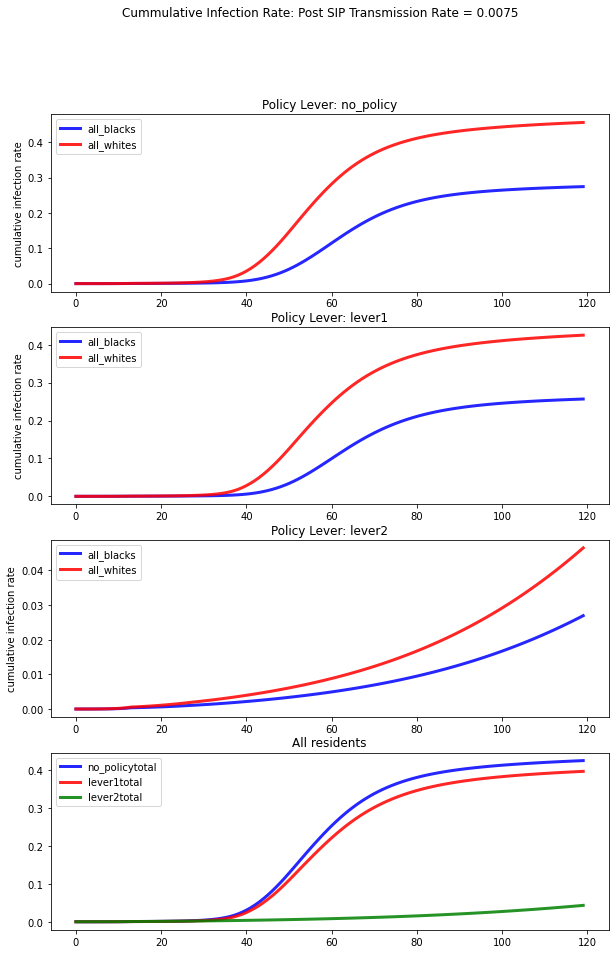

In [38]:
# Initial Input Parameters
PRISON_PEAK_DATE = 35
TRANSMISSION_RATE = 0.015
POST_SIP_TRANMISSION_RATE = TRANSMISSION_RATE/2
SIP_START_DATE  = 14
INITIAL_INFECTION_RATE =1

OUTPUT_DIR = 'output/'  #input2/CONTACT_MATRIX_POST_SIP.csv
CONTACT_MATRIX_PATH = 'CONTACT_MATRIX_POST_SIP.csv'
PRE_SOCIAL_DISTANCE_CONTACT_MATRIX = "CONTACT_MATRIX_PRE_SIP.csv"
GROUP_SIZE_PATH = 'GROUP_SIZE.csv'
DAYS = 200
prison_infection_rate = 0.35
starting_params = mp.ModelParams(TRANSMISSION_RATE, SIP_START_DATE, INITIAL_INFECTION_RATE,
                                 PRISON_PEAK_DATE, prison_infection_rate,
                                 post_sip_t=POST_SIP_TRANMISSION_RATE)

summary_stats, infection_maps, s_maps, group_sizes = run_models({inputs.ORIGINAL_FOLDER: original_dir,
                                                                  inputs.LEVER_1_FOLDER : lever_1_dir,
                                                                  inputs.LEVER_2_FOLDER: lever_2_dir},
                                                                  starting_params, DAYS)

summary_stats.to_csv(os.path.join(OUTPUT_DIR, f'full_summary_stats_{TRANSMISSION_RATE}.csv'))

make_susceptable_plot(s_maps, group_sizes, f'Cummulative Infection Rate: Post SIP Transmission Rate = {POST_SIP_TRANMISSION_RATE}')

(3, 2)


array([[<AxesSubplot:ylabel='cumulative infection rate'>,
        <AxesSubplot:ylabel='cumulative infection rate'>],
       [<AxesSubplot:ylabel='cumulative infection rate'>,
        <AxesSubplot:ylabel='cumulative infection rate'>],
       [<AxesSubplot:ylabel='cumulative infection rate'>,
        <AxesSubplot:ylabel='cumulative infection rate'>]], dtype=object)

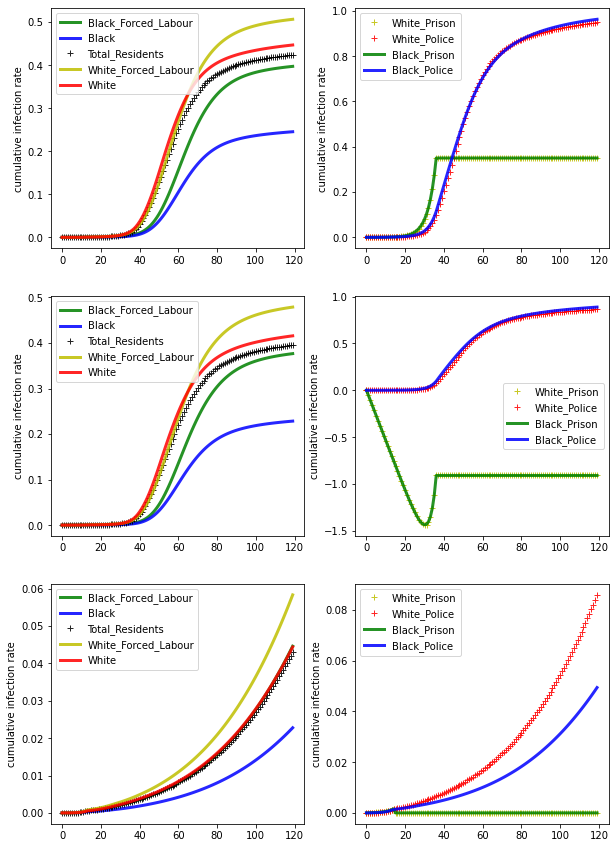

In [39]:
plot_all_groups(s_maps, group_sizes)

(3, 2)


array([[<AxesSubplot:ylabel='Daily Infection Rate'>,
        <AxesSubplot:ylabel='Daily Infection Rate'>],
       [<AxesSubplot:ylabel='Daily Infection Rate'>,
        <AxesSubplot:ylabel='Daily Infection Rate'>],
       [<AxesSubplot:ylabel='Daily Infection Rate'>,
        <AxesSubplot:ylabel='Daily Infection Rate'>]], dtype=object)

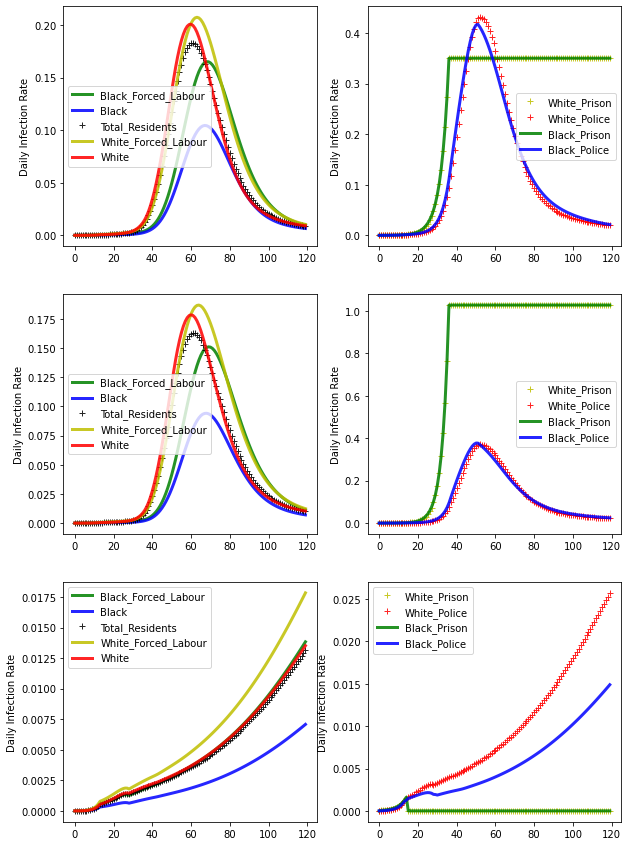

In [40]:

def plot_all_groups_infection(infection_maps, group_sizes, policies = ['no_policy', 'lever1', 'lever2'],
                              DAY_LIMIT = 120):
    fig, ax  = plt.subplots(len(policies),2, figsize = (10, 15))
    print(ax.shape)
    populations = {
        'Black_Forced_Labour': 'g',
        'Black': 'b',
        'Total_Residents': 'k+',
        'White_Forced_Labour' : 'y',
        'White': 'r'
    }
    
    prisons = {
        'White_Prison' : 'y+',
        'White_Police' : 'r+',
        'Black_Prison': 'g',
        'Black_Police': 'b'
    }
    
    
    p = group_sizes.loc['no_policy_original']
    maps = [populations, prisons]
    for j in range(0, len(policies)):
        policy_name = policies[j]
        policy_df = infection_maps[policy_name].iloc[0: DAY_LIMIT]
        df = policy_df[policy_df['model_name'] == 'original']
        
        for i in [0,1]:
            for group, color in maps[i].items():
                ax[j,i].plot(df['Day'].values, df[group]/p[group], color, alpha=0.85, lw=3, label = group)

            ax[j,i].legend()
            ax[j,i].set_ylabel('Daily Infection Rate')
    return ax
plot_all_groups_infection(infection_maps, group_sizes)  

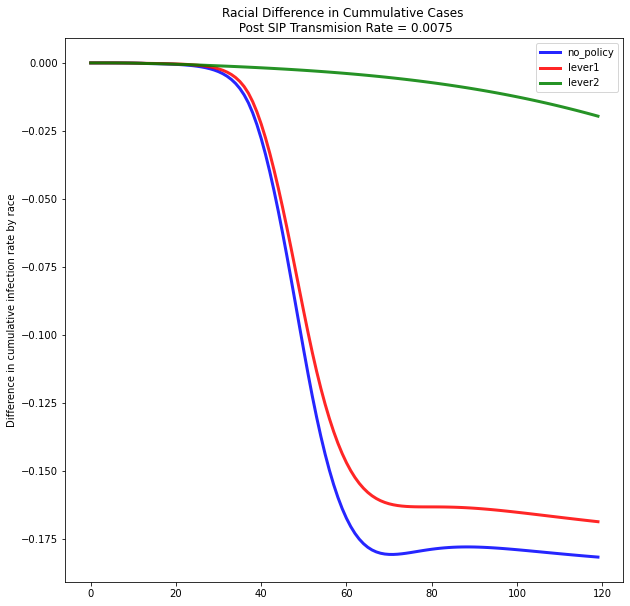

In [31]:
def make_susceptable_plot_racial_dif(s_maps, group_sizes, suptitle):
    fig, ax  = plt.subplots(1, 1, figsize = (10, 10))
    no_policy = s_maps['no_policy']
    p = group_sizes.loc['no_policy_original']
    no_policy['all_blacks'] = no_policy['Black'] + no_policy['Black_Forced_Labour']
    no_policy['all_whites'] = no_policy['White'] + no_policy['White_Forced_Labour']
    p['all_whites'] = p['White'] + p['White_Forced_Labour']
    p['all_blacks'] = p['Black'] + p['Black_Forced_Labour']
    policies = ['no_policy', 'lever1', 'lever2']
    colors = {
        'no_policy': 'b',
        'lever1': 'r',
        'lever2': 'g'
    }
    for i in range(0, 3):
        policy_name = policies[i]
        policy_df = s_maps[policy_name].iloc[0:120]
        df = policy_df[policy_df['model_name'] == 'original']
        p = group_sizes.loc['no_policy_original']
        df['all_blacks'] = df['Black'] + df['Black_Forced_Labour']
        df['all_whites'] = df['White'] + df['White_Forced_Labour']
        p['all_whites'] = p['White'] + p['White_Forced_Labour']
        p['all_blacks'] = p['Black'] + p['Black_Forced_Labour']

        color = colors[policy_name]
        race_diff = 1 - (df['all_blacks']/p['all_blacks']) - (1 - df['all_whites']/p['all_whites'])
        ax.plot(df['Day'].values, race_diff , color, alpha=0.85, lw=3, label = policy_name)
        ax.set_title('Policy Lever: ' + policy_name)
        ax.set_ylabel('Difference in cumulative infection rate by race')
        ax.legend()
        
    ax.set_title(suptitle)
    plt.savefig(f'figures/{suptitle}.png')
make_susceptable_plot_racial_dif(s_maps, group_sizes, 
                                 f'Racial Difference in Cummulative Cases \n Post SIP Transmision Rate = {POST_SIP_TRANMISSION_RATE}')

In [ ]:
summary_stats[summary_stats['Policy_Lever'] == 'lever1'][['model_name', 'cumulative_infected_40_days']]

In [32]:
def make_susceptable_plot_model_dif(s_maps, group_sizes, suptitle):
    fig, ax  = plt.subplots(2, 3, figsize = (20, 10))
    no_policy = s_maps['no_policy']
    p = group_sizes.loc['no_policy_original']
    no_policy['all_blacks'] = no_policy['Black'] + no_policy['Black_Forced_Labour']
    no_policy['all_whites'] = no_policy['White'] + no_policy['White_Forced_Labour']
    p['all_whites'] = p['White'] + p['White_Forced_Labour']
    p['all_blacks'] = p['Black'] + p['Black_Forced_Labour']
    policies = ['no_policy', 'lever1', 'lever2']
    colors = {
        'no_policy': 'k',
        'lever1': 'r',
        'lever2': 'b'
    }
    policy_df = s_maps['no_policy']
    df_original = policy_df[policy_df['model_name'] == 'original']
    df_original['all_blacks'] = df_original['Black'] + df_original['Black_Forced_Labour']
    df_original['all_whites'] = df_original['White'] + df_original['White_Forced_Labour']
    
    
    for policy in ['lever1', 'lever2']:
        policy_name = policy
        policy_df = s_maps[policy_name]
        color = colors[policy]
        df = policy_df[policy_df['model_name'] == 'original']
        p = group_sizes.loc['no_policy_original']
        df['all_blacks'] = df['Black'] + df['Black_Forced_Labour']
        df['all_whites'] = df['White'] + df['White_Forced_Labour']
        p['all_whites'] = p['White'] + p['White_Forced_Labour']
        p['all_blacks'] = p['Black'] + p['Black_Forced_Labour']
        groups = ['all_blacks', 'all_whites', 'Total_Residents']
        for i in range(0, 3):
            group = groups[i]
            
            diff = 1 - (df_original[group]/p[group]) - (1 - (df[group]/p[group]))
            ax[0,i].plot(df['Day'].values, diff , color, alpha=0.85, lw=3, label = policy_name)
            ax[0, i].set_title(
                'Difference in rates ' + f'for {group}')
            ax[0, i].legend()
            
            diff_total = (1 - df_original[group]) - (1 - df[group])
            ax[1,i].plot(df['Day'].values, diff_total , color, alpha=0.85, lw=3, label = policy_name)
            ax[1,i].set_title(
                'Difference in cum cases ' + f'for {group}')
            ax[1, i].legend()
    fig.suptitle(suptitle)
    plt.savefig('figures/{suptitle}.png')


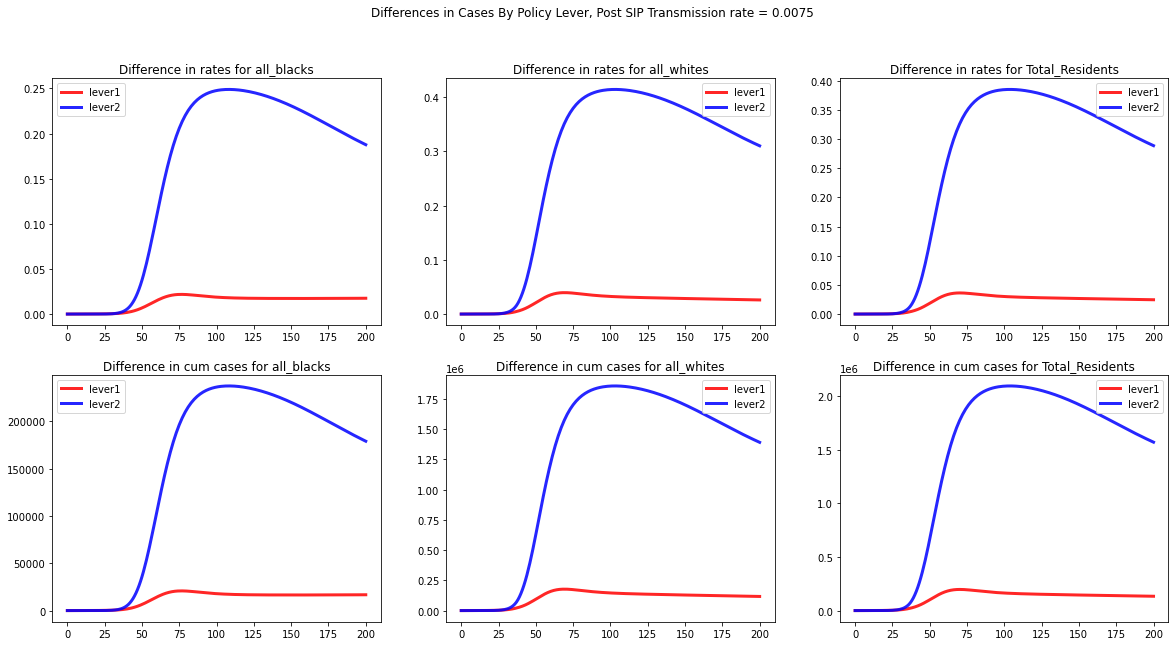

In [33]:
make_susceptable_plot_model_dif(s_maps, group_sizes, f'Differences in Cases By Policy Lever, Post SIP Transmission rate = {POST_SIP_TRANMISSION_RATE}')

policy_lever_1
running poilcy 1 code with policy 2 matrix
policy_lever_2


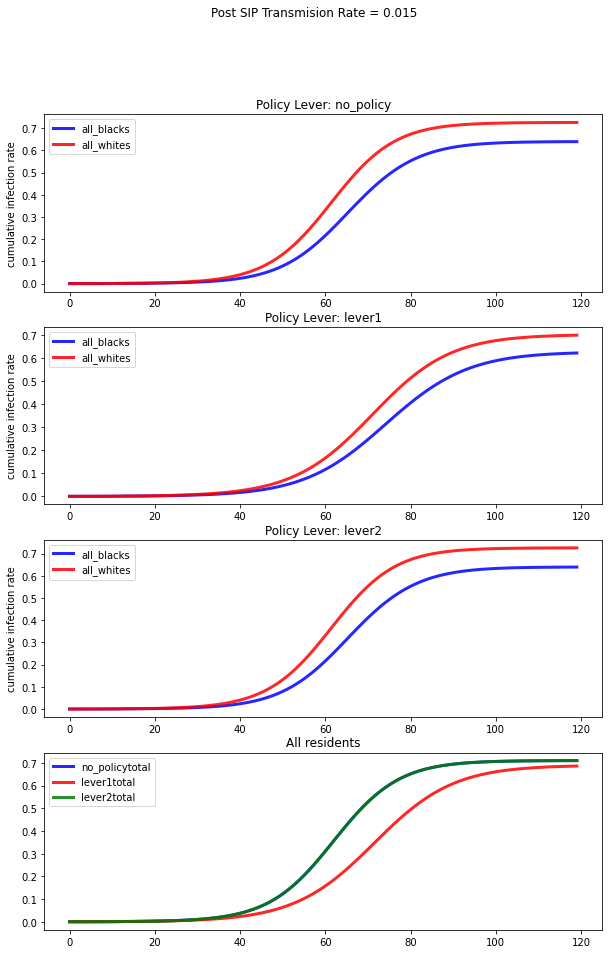

In [34]:
# Initial Input Parameters
PRISON_PEAK_DATE = 35
TRANSMISSION_RATE = 0.015
SIP_START_DATE  = 14
INITIAL_INFECTION_RATE =10

OUTPUT_DIR = 'output/'  #input2/CONTACT_MATRIX_POST_SIP.csv
CONTACT_MATRIX_PATH = 'CONTACT_MATRIX_POST_SIP.csv'
PRE_SOCIAL_DISTANCE_CONTACT_MATRIX = "CONTACT_MATRIX_PRE_SIP.csv"
GROUP_SIZE_PATH = 'GROUP_SIZE.csv'
DAYS = 120

starting_params = mp.ModelParams(TRANSMISSION_RATE, SIP_START_DATE, INITIAL_INFECTION_RATE,
                                 prison_infection_rate, prison_infection_rate)

summary_stats, infection_maps, s_maps, group_sizes = run_models({inputs.ORIGINAL_FOLDER: original_dir,
                                                                  inputs.LEVER_1_FOLDER : lever_1_dir,
                                                                  inputs.LEVER_2_FOLDER: lever_2_dir},
                                                                  starting_params, DAYS)

summary_stats.to_csv(os.path.join(OUTPUT_DIR, f'full_summary_stats_{TRANSMISSION_RATE}.csv'))

make_susceptable_plot(s_maps, group_sizes, f'Post SIP Transmision Rate = {TRANSMISSION_RATE}')

In [ ]:
# Make Some Plots to Visualize The Infection In the Synthetic City